In [ ]:
from sklearn.linear_model import LogisticRegression
import glob
import os.path
import numpy as np
import sys
import codecs
import functools
from collections import Counter

In [ ]:
!pip install transformers
!pip install tensorboardx
!pip install simpletransformers

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from simpletransformers.classification import ClassificationModel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
source = '/content/drive/My Drive/Colab Notebooks/Propaganda challenge'

train_folder = source + '/' + "datasets/train-articles" # check that the path to the datasets folder is correct, 
dev_folder = source + '/' + "datasets/dev-articles"     # if not adjust these variables accordingly
test_folder = source + '/' + "datasets/test-articles"
train_labels_file = source + '/' + "datasets/train-task2-TC.labels"
dev_template_labels_file = source + '/' + "datasets/dev-task-TC-template.out"
test_template_labels_file = source + '/' + "datasets/test-task-TC-template.out"
task_TC_output_file = "result.txt"

In [ ]:
def read_articles_from_file_list(folder_name, file_pattern="*.txt"):
    """
    Read articles from files matching patterns <file_pattern> from  
    the directory <folder_name>. 
    The content of the article is saved in the dictionary whose key
    is the id of the article (extracted from the file name).
    Each element of <sentence_list> is one line of the article.
    """
    file_list = glob.glob(os.path.join(folder_name, file_pattern))
    articles = {}
    article_id_list, sentence_id_list, sentence_list = ([], [], [])
    for filename in sorted(file_list):
        article_id = os.path.basename(filename).split(".")[0][7:]
        with codecs.open(filename, "r", encoding="utf8") as f:
            articles[article_id] = f.read()
    return articles

In [ ]:
def read_predictions_from_file(filename):
    """
    Reader for the gold file and the template output file. 
    Return values are four arrays with article ids, labels 
    (or ? in the case of a template file), begin of a fragment, 
    end of a fragment. 
    """
    articles_id, span_starts, span_ends, gold_labels = ([], [], [], [])
    with open(filename, "r") as f:
        for row in f.readlines():
            article_id, gold_label, span_start, span_end = row.rstrip().split("\t")
            articles_id.append(article_id)
            gold_labels.append(gold_label)
            span_starts.append(span_start)
            span_ends.append(span_end)
    return articles_id, span_starts, span_ends, gold_labels


In [ ]:
# loading articles' content from *.txt files in the train folder
articles = read_articles_from_file_list(train_folder)

In [ ]:
len(articles)

371

In [ ]:
# loading gold labels, articles ids and sentence ids from files *.task-TC.labels in the train labels folder 
ref_articles_id, ref_span_starts, ref_span_ends, train_gold_labels = read_predictions_from_file(train_labels_file)
print("Loaded %d annotations from %d articles" % (len(ref_span_starts), len(set(ref_articles_id))))

Loaded 6129 annotations from 357 articles


In [ ]:
# reading data from the development set
dev_articles = read_articles_from_file_list(dev_folder)
dev_article_ids, dev_span_starts, dev_span_ends, dev_labels = read_predictions_from_file(dev_template_labels_file)

In [ ]:
test_articles = read_articles_from_file_list(test_folder)
test_article_ids, test_span_starts, test_span_ends, test_labels = read_predictions_from_file(test_template_labels_file)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()

In [ ]:
le.fit(train_gold_labels)

LabelEncoder()

In [ ]:
labels = le.transform(train_gold_labels)

In [ ]:
le.classes_

array(['Appeal_to_Authority', 'Appeal_to_fear-prejudice',
       'Bandwagon,Reductio_ad_hitlerum', 'Black-and-White_Fallacy',
       'Causal_Oversimplification', 'Doubt', 'Exaggeration,Minimisation',
       'Flag-Waving', 'Loaded_Language', 'Name_Calling,Labeling',
       'Repetition', 'Slogans', 'Thought-terminating_Cliches',
       'Whataboutism,Straw_Men,Red_Herring'], dtype='<U34')

In [ ]:
c = Counter(train_gold_labels)
c

Counter({'Appeal_to_Authority': 144,
         'Appeal_to_fear-prejudice': 294,
         'Bandwagon,Reductio_ad_hitlerum': 72,
         'Black-and-White_Fallacy': 107,
         'Causal_Oversimplification': 209,
         'Doubt': 493,
         'Exaggeration,Minimisation': 466,
         'Flag-Waving': 229,
         'Loaded_Language': 2123,
         'Name_Calling,Labeling': 1058,
         'Repetition': 621,
         'Slogans': 129,
         'Thought-terminating_Cliches': 76,
         'Whataboutism,Straw_Men,Red_Herring': 108})

In [ ]:
def get_spans(articles, articles_ids, span_starts, span_ends):
  result = []
  for article_id, start, end in zip(articles_ids, span_starts, span_ends):
    article = articles[article_id]
    #print(int(start), int(end))
    span = article[int(start): int(end)]
    result.append(span)

  return result

In [ ]:
train_spans = get_spans(articles, ref_articles_id, ref_span_starts, ref_span_ends)

In [ ]:
dev_spans = get_spans(dev_articles, dev_article_ids, dev_span_starts, dev_span_ends)

In [ ]:
test_spans = get_spans(test_articles, test_article_ids, test_span_starts, test_span_ends)

In [ ]:
train_arr = [[text, label] for text, label in zip(train_spans, labels)]

In [ ]:
train_df = pd.DataFrame(data=train_arr)

In [ ]:
y = train_df.iloc[:, 1]

# Transformer training

weighted training

In [ ]:
c = Counter(labels)

In [ ]:
weights = [sum(c.values()) / c[i] for i in range(14)]

In [ ]:
weights = [x / sum(weights) for x in weights]

In [ ]:
weights

[0.08669510719509899,
 0.04246290964657909,
 0.17339021439019797,
 0.11667378912237619,
 0.05973251404829786,
 0.02532270879532303,
 0.026789904369300975,
 0.05451570059429804,
 0.0058804029373972,
 0.011799712132414228,
 0.020103213262631647,
 0.09677593361313373,
 0.1642644136328191,
 0.11559347626013197]

In [ ]:
model = ClassificationModel('roberta', 'roberta-base', weight=weights, num_labels=14, args=({'fp16': False, 'overwrite_output_dir': True, 'max_seq_length': 512, 'num_train_epochs': 5}))

In [ ]:
model.train_model(train_df)

Converting to features started. Cache is not used.


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:246: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 2.613912

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 3.032972

Running loss: 3.663283

Running loss: 1.072565

Running loss: 0.104369

Running loss: 0.015056
Training of roberta model complete. Saved to outputs/.


In [ ]:
preds, raw_outputs = model.predict(test_spans)

Converting to features started. Cache is not used.


In [ ]:
predictions = le.inverse_transform(preds)

In [ ]:
# writing predictions to file
with open(task_TC_output_file, "w") as fout:
    for article_id, prediction, span_start, span_end in zip(dev_article_ids, predictions, dev_span_starts, dev_span_ends):
        fout.write("%s\t%s\t%s\t%s\n" % (article_id, prediction, span_start, span_end))
print("Predictions written to file " + task_TC_output_file)

Predictions written to file result.txt


In [ ]:
with open(task_TC_output_file, "w") as fout:
    for article_id, prediction, span_start, span_end in zip(test_article_ids, predictions, test_span_starts, test_span_ends):
        fout.write("%s\t%s\t%s\t%s\n" % (article_id, prediction, span_start, span_end))
print("Predictions written to file " + task_TC_output_file)

Predictions written to file result.txt


In [ ]:
predictions

# Undersampling

In [ ]:
train_df = pd.DataFrame(data=train_arr)

In [ ]:
cat1 = train_df[train_df[1] == 8].index
cat2 = train_df[train_df[1] == 9].index

In [ ]:
from random import sample

In [ ]:
cat1_drop = sample(list(cat1), int(len(cat1) * 0.5))

In [ ]:
cat2_drop = sample(list(cat2), int(len(cat2) * 0.2))

In [ ]:
train_df = train_df.drop(cat1_drop)

In [ ]:
train_df = train_df.drop(cat2_drop)

In [ ]:
len(train_df)

4857

In [ ]:
from simpletransformers.classification import ClassificationModel

In [ ]:
model = ClassificationModel('roberta', 'roberta-base', num_labels=14, args=({'fp16': False, 'overwrite_output_dir': True, 'max_seq_length': 512, 'num_train_epochs': 5}))

In [ ]:
model.train_model(train_df)

Converting to features started. Cache is not used.


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:244: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 2.252989

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 3.666293
Training of roberta model complete. Saved to outputs/.


In [ ]:
preds, raw_outputs = model.predict(dev_spans)

Converting to features started. Cache is not used.


In [ ]:
predictions = le.inverse_transform(preds)

In [ ]:
# writing predictions to file
with open(task_TC_output_file, "w") as fout:
    for article_id, prediction, span_start, span_end in zip(dev_article_ids, predictions, dev_span_starts, dev_span_ends):
        fout.write("%s\t%s\t%s\t%s\n" % (article_id, prediction, span_start, span_end))
print("Predictions written to file " + task_TC_output_file)

Predictions written to file result.txt


# Context 

In [ ]:
c = Counter(train_gold_labels)
c

Counter({'Appeal_to_Authority': 144,
         'Appeal_to_fear-prejudice': 294,
         'Bandwagon,Reductio_ad_hitlerum': 72,
         'Black-and-White_Fallacy': 107,
         'Causal_Oversimplification': 209,
         'Doubt': 493,
         'Exaggeration,Minimisation': 466,
         'Flag-Waving': 229,
         'Loaded_Language': 2123,
         'Name_Calling,Labeling': 1058,
         'Repetition': 621,
         'Slogans': 129,
         'Thought-terminating_Cliches': 76,
         'Whataboutism,Straw_Men,Red_Herring': 108})

In [ ]:
def get_spans_with_context(articles, articles_ids, span_starts, span_ends):
  result = []
  a = {'.', '?', '!', '\n', ','}

  for article_id, start, end in zip(articles_ids, span_starts, span_ends):
    article = articles[article_id]
    occurences = [article.find(i, int(end)) for i in a]
    final = min([x for x in occurences if x != -1])

    span = article[int(start): int(final)]
    result.append(span)
    
  return result

In [ ]:
train_spans = get_spans_with_context(articles, ref_articles_id, ref_span_starts, ref_span_ends)

In [ ]:
dev_spans = get_spans_with_context(dev_articles, dev_article_ids, dev_span_starts, dev_span_ends)

In [ ]:
train_arr = [[text, label] for text, label in zip(train_spans, labels)]

In [ ]:
train_df = pd.DataFrame(data=train_arr)

In [ ]:
model = ClassificationModel('roberta', 'roberta-base', num_labels=14, args=({'fp16': False, 'overwrite_output_dir': True, 'max_seq_length': 512, 'num_train_epochs': 5}))

In [ ]:
model.train_model(train_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:256: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Features loaded from cache at cache_dir/cached_train_roberta_512_14_6129


Running loss: 2.492530

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.272029

Running loss: 2.513307

Running loss: 0.042421

Running loss: 1.593611

Running loss: 0.460653Training of roberta model complete. Saved to outputs/.


In [ ]:
preds, raw_outputs = model.predict(dev_spans)

Features loaded from cache at cache_dir/cached_dev_roberta_512_14_1063


In [ ]:
predictions = le.inverse_transform(preds)

In [ ]:
# writing predictions to file
with open(task_TC_output_file, "w") as fout:
    for article_id, prediction, span_start, span_end in zip(dev_article_ids, predictions, dev_span_starts, dev_span_ends):
        fout.write("%s\t%s\t%s\t%s\n" % (article_id, prediction, span_start, span_end))
print("Predictions written to file " + task_TC_output_file)

Predictions written to file result.txt


# EDA

In [ ]:
def get_len(row):
  return len(row.split())

In [ ]:
train_df['size'] = train_df[0].apply(lambda x: get_len(x))

In [ ]:
def plot_len(train_df):
  fig, axes = plt.subplots(4, 4, figsize=(12, 12))

  for i in range(14):
    ax = axes.ravel()[i]
    cat = train_df[train_df[1] == i]

    title = le.inverse_transform([i])[0]
    #ax.title.set_text(title)
    ax.set_title(title, fontsize=10)

    ax.hist(cat['size'])

In [ ]:
def plot_boxes(train_df):
  data = []
  labels = []

  fig, ax = plt.subplots(figsize=(10, 10))

  for i in range(14):
    cat = train_df[train_df[1] == i]
    pl = ax.boxplot(list(cat['size']), positions=[i], boxprops=dict(color="C" + str(i)))
    data.append(pl["boxes"][0])
    labels.append(str(i) + ". " + le.inverse_transform([i])[0])
  
  #ax7.set_title('Box plots of length distribution in words inside classes')
  
  ax.legend(data, labels, loc='upper right')

  fig.savefig('boxes.png')
  plt.show()

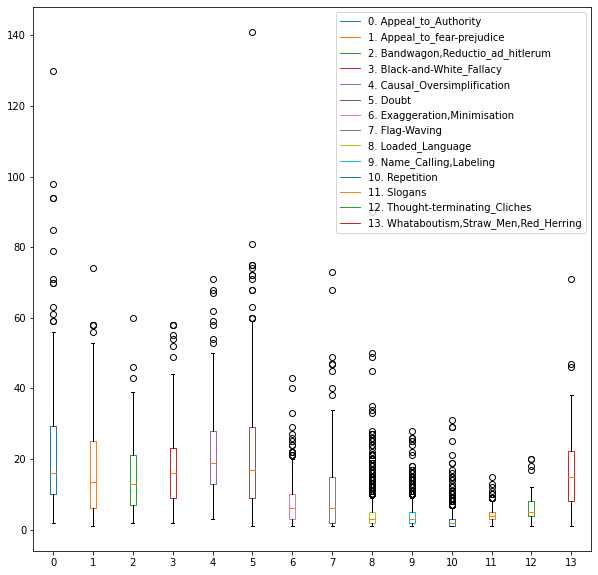

In [ ]:
plot_boxes(train_df)

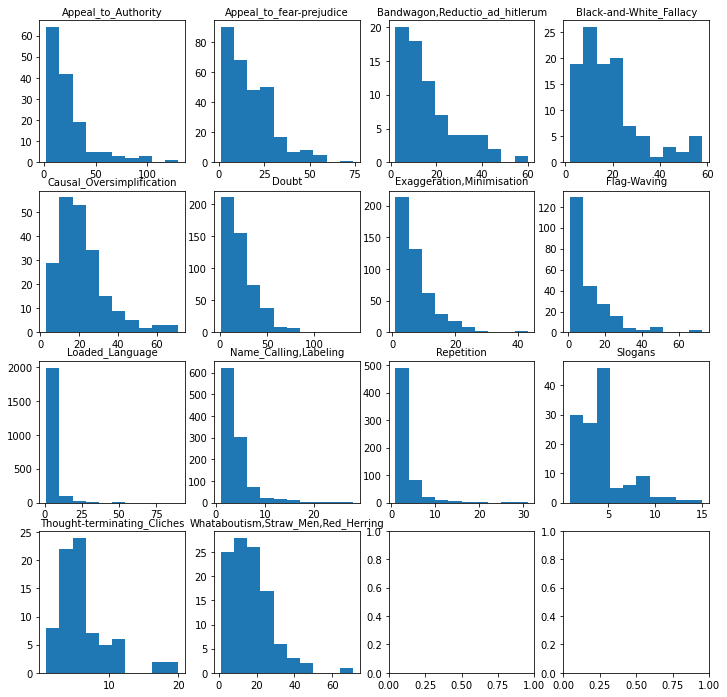

In [ ]:
plot_len(train_df=train_df)